In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
os.chdir("/kaggle/input/house-prices-advanced-regression-techniques")
os.getcwd()

'/kaggle/input/house-prices-advanced-regression-techniques'

In [3]:
import cudf as cd
import cupy as cp
import cuml as cm
import pandas as pd
import sklearn
import numpy as np
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [4]:
sample = pd.read_csv('sample_submission.csv')
test['SalePrice'] = sample['SalePrice']
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,169277.052498
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,187758.393989
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,183583.683570
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,179317.477511
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,150730.079977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,184924.279659


In [5]:
X = df.iloc[:,:-1]
columns = X.columns
Y = df.iloc[:,-1]
X_test = test.iloc[:,:-1]
Y_test = test.iloc[:,-1]

In [6]:
X = X.append(X_test,ignore_index=True)
Y = Y.append(Y_test,ignore_index=True)

In [7]:
from sklearn.preprocessing import LabelEncoder
temp = X.select_dtypes(include = "object").columns
temp = list(temp)
X[temp].apply(lambda col: col.astype(str))

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
1,RL,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
2,RL,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
3,RL,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,nan,nan,nan,WD,Abnorml
4,RL,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,nan,nan,nan,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,RM,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,nan,nan,nan,nan,Y,nan,nan,nan,WD,Normal
2915,RM,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,CarPort,Unf,TA,TA,Y,nan,nan,nan,WD,Abnorml
2916,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Detchd,Unf,TA,TA,Y,nan,nan,nan,WD,Abnorml
2917,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,nan,nan,nan,nan,Y,nan,MnPrv,Shed,WD,Normal


In [8]:
X_temp = X[temp].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)), axis=0, result_type='expand')

In [9]:
X = X.drop(temp,axis=1)
X = pd.concat([X,X_temp],axis=1)

In [10]:
X = X.replace(np.nan,-1)

In [11]:
X

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,1,1,4,4,2,3,4,4,8,4
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,1,1,4,4,2,3,4,4,8,4
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,1,1,4,4,2,3,4,4,8,4
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,5,2,4,4,2,3,4,4,8,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,1,1,4,4,2,3,4,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,6,3,5,5,2,3,4,4,8,4
2915,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,4,2,4,4,2,3,4,4,8,0
2916,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,5,2,4,4,2,3,4,4,8,0
2917,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,6,3,5,5,2,3,2,2,8,4


In [12]:
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=500)
rnd_clf.fit(X,Y)
importance_dict = {}
for j in X.columns:
    importance_dict[j]=0
for name,score in zip(columns,rnd_clf.feature_importances_):
    importance_dict[name]=importance_dict[name]+score
    print(name,score)
for k in X.columns:
    if(importance_dict[k]<0.0008):
        X=X.drop([k],1)

Id 0.2292444770020646
MSSubClass 0.002002414035218161
MSZoning 0.00514496706600942
LotFrontage 0.02592834223551722
LotArea 0.1959472087636184
Street 0.004622495527888464
Alley 0.01910967118021862
LotShape 0.00809239071102902
LandContour 0.006023528003261595
Utilities 0.024042444619871237
LotConfig 0.0007192795304238023
LandSlope 0.005183899495419139
Neighborhood 0.04685759664391811
Condition1 0.020118107440606388
Condition2 0.035514965100528255
BldgType 0.00010257263712646636
HouseStyle 0.2068808774661083
OverallQual 0.001016137323517264
OverallCond 0.00034565815614811206
YearBuilt 0.0019777486690413593
YearRemodAdd 0.0008898129926909482
RoofStyle 0.01875753282117964
RoofMatl 0.0006113525202307429
Exterior1st 0.005790119180851894
Exterior2nd 0.002091402238091097
MasVnrType 0.006620718252278669
MasVnrArea 0.03139307116972333
ExterQual 0.016794450940252136
ExterCond 0.004773124112492348
Foundation 0.004168304289469134
BsmtQual 0.0006729779843152865
BsmtCond 0.0006108620216893799
BsmtExpo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


<BarContainer object of 80 artists>

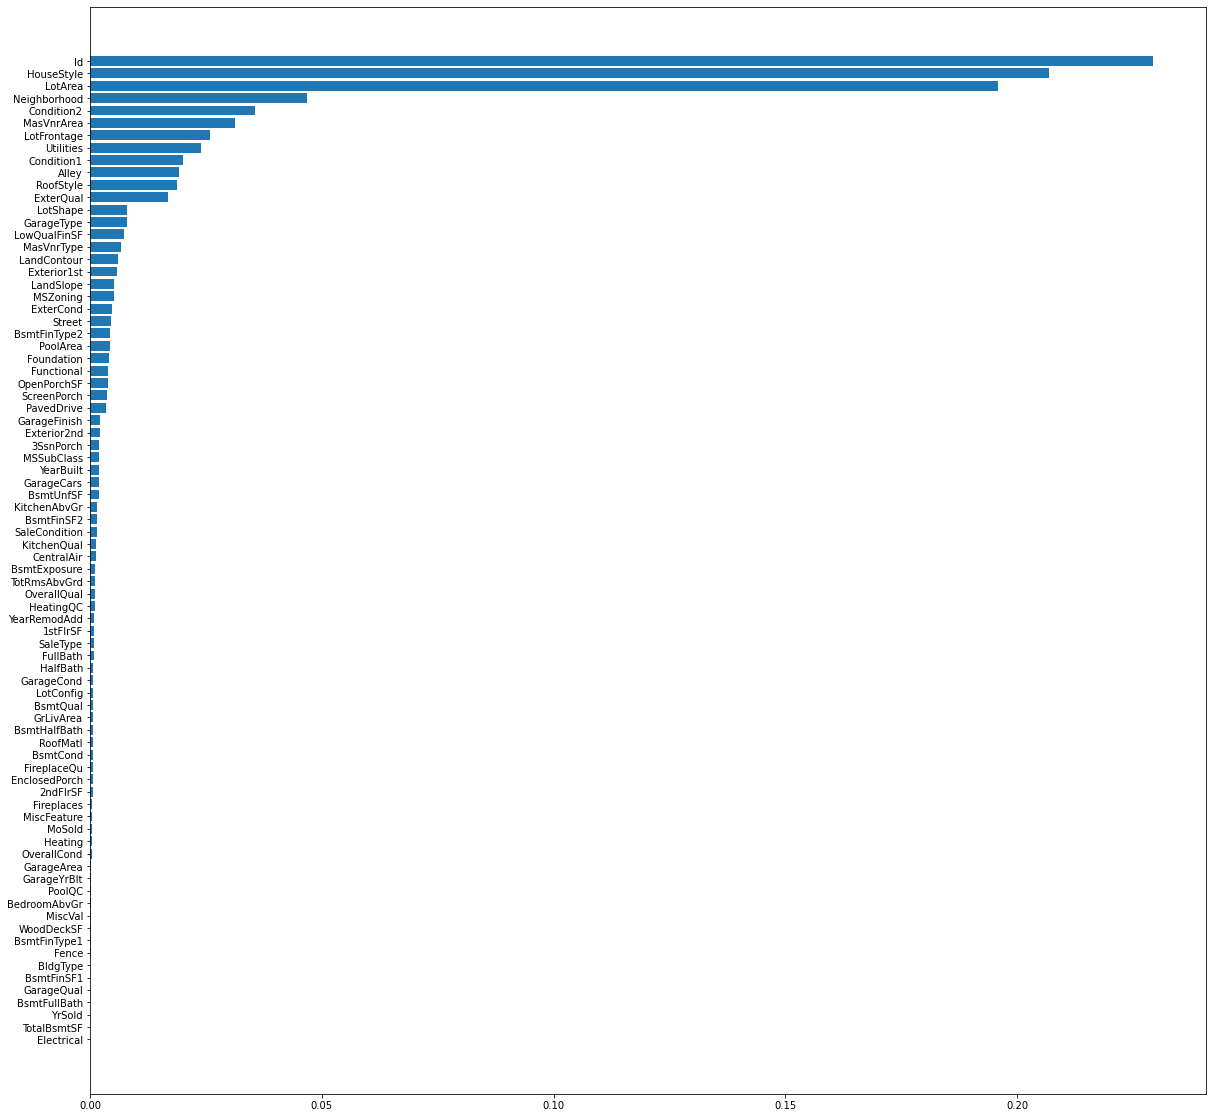

In [13]:
sorted_idx = rnd_clf.feature_importances_.argsort()
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.barh(columns[sorted_idx],rnd_clf.feature_importances_[sorted_idx])

In [14]:
from sklearn.model_selection import train_test_split
X,X_test,Y,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [15]:
columns=X.columns
len(columns)

48

In [16]:
from cuml.preprocessing import StandardScaler
for i in columns :
    scaler = StandardScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1,1))
    X_test[i] = scaler.transform(X_test[i].values.reshape(-1,1))

In [17]:
X = X.iloc[:,1:]
X_test = X_test.iloc[:,1:]

In [18]:
scaler = StandardScaler()
Y = scaler.fit_transform(Y.values.reshape(-1,1))
Y_test = scaler.transform(Y_test.values.reshape(-1,1))

In [19]:
from cuml import LinearRegression
from cuml.linear_model import LinearRegression
X_new = cd.DataFrame(X)
Y_new = cd.DataFrame(Y)
lr = LinearRegression(fit_intercept = False,algorithm = "svd")
reg = lr.fit(X_new,Y_new)
preds = lr.predict(X_test)
from cuml.metrics import mean_squared_error
from cuml.metrics import mean_absolute_error
from cuml.metrics import r2_score
MSE = mean_squared_error(Y_test,preds)
MAE = mean_absolute_error(Y_test,preds)
R2 = r2_score(Y_test,preds)
print(MSE,MAE,R2)

1.197427657187196 0.8087265929205371 0.447739578242457


In [20]:
from cuml.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X,Y)
preds = reg.predict(X_test)
from cuml.metrics import mean_squared_error
from cuml.metrics import mean_absolute_error
from cuml.metrics import r2_score
MSE = mean_squared_error(Y_test,preds)
MAE = mean_absolute_error(Y_test,preds)
R2 = r2_score(Y_test,preds)
print(MSE,MAE,R2)

[W] [21:03:30.312472] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
0.7575460208875798 0.5640392590625964 -0.0010559335664261926


In [21]:
from cuml import Ridge
from cuml.linear_model import Ridge
ridge = Ridge(alpha=0.5,fit_intercept = True, normalize = False,solver = "svd")
result_ridge = ridge.fit(X, Y)
preds = result_ridge.predict(X_test)
from cuml.metrics import mean_squared_error
from cuml.metrics import mean_absolute_error
from cuml.metrics import r2_score
MSE = mean_squared_error(Y_test,preds)
MAE = mean_absolute_error(Y_test,preds)
R2 = r2_score(Y_test,preds)
print(MSE,MAE,R2)

1.1973487760688313 0.8086957095471886 0.4477531095912599


In [22]:
from cuml.linear_model import Lasso
ls = Lasso(alpha = 0.05)
result_lasso = ls.fit(X, Y)
preds = result_lasso.predict(X_test)
from cuml.metrics import mean_squared_error
from cuml.metrics import mean_absolute_error
from cuml.metrics import r2_score
MSE = mean_squared_error(Y_test,preds)
MAE = mean_absolute_error(Y_test,preds)
R2 = r2_score(Y_test,preds)
print(MSE,MAE,R2)

1.1010737967691957 0.7709078498437196 0.4396586494742295


In [23]:
from cuml.linear_model import ElasticNet
enet = ElasticNet(alpha = 0.3, l1_ratio=0.1)
result_enet = enet.fit(X, Y)
preds = result_enet.predict(X_test)
from cuml.metrics import mean_squared_error
from cuml.metrics import mean_absolute_error
from cuml.metrics import r2_score
MSE = mean_squared_error(Y_test,preds)
MAE = mean_absolute_error(Y_test,preds)
R2 = r2_score(Y_test,preds)
print(MSE,MAE,R2)

1.077315068107112 0.7592178406044603 0.44337245506996614
